<a href="https://colab.research.google.com/github/chiggy31/Fabric-defect-detection/blob/main/Fabric_Vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import sklearn
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR']="/content/drive/MyDrive/datasets/images"

%cd /content/drive/MyDrive/datasets/images


Mounted at /content/drive
/content/drive/MyDrive/datasets/images


In [ ]:
project_path = "/content/drive/MyDrive/datasets/images"

<ipython-input-4-01c94d781d4d>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(pic)


picture shape: (1488, 1984)


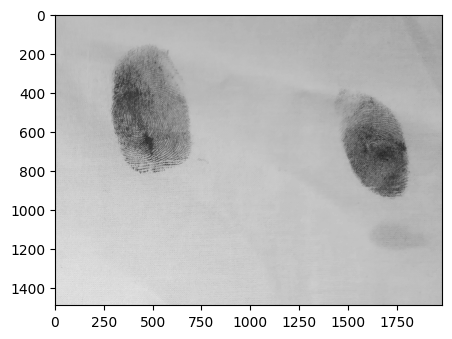

In [ ]:
# load a picture
pic = "/content/drive/MyDrive/datasets/images/stain/11.jpg"
im = imageio.imread(pic)
print("picture shape: {}".format(im.shape))
plt.figure(figsize=(5,5))
plt.imshow(im, cmap='gray')
plt.show()

In [ ]:
from keras.applications import VGG19,Xception,VGG16
from keras.layers import Dense , Conv2D , MaxPooling2D , Dropout,Flatten,Convolution2D
from keras.models  import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Loading the VGG19 Model
* VGG19 Model: VGG19 is a pre-trained CNN model with 19 layers, known for its depth and effectiveness in image recognition tasks.
* include_top=True: This includes the fully connected layers at the top of the network, which are used for classification.
* weights='imagenet': This loads weights pre-trained on the ImageNet dataset.
* models.trainable = False: All layers of the VGG19 model are set to be non-trainable to prevent updating their weights during training. This is done to leverage the learned features from ImageNet without altering them.

In [ ]:
vgg_model =  VGG19(include_top=True , weights='imagenet')
for models in vgg_model.layers:
  models.trainable= False

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
#converting from functionally model to sequential model
#removing the last 2 alyer to get rid of output layer in VGG16
vgg_model = keras.Model(inputs=vgg_model.input, outputs=vgg_model.layers[-2].output)
# A new sequential model is created and all layers from the modified VGG19 model are added to it.
model = keras.Sequential()
for layer in vgg_model.layers:
  model.add(layer)

## Fine-Tuning the Pre-Trained Model:
Allowing some layers of the pre-trained VGG19 model to be trainable can improve accuracy by adapting learned features to your specific dataset.
Unfreeze some of the last layers of the VGG19 model and re-train them.

In [ ]:
for layer in vgg_model.layers[-2:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.layers import BatchNormalization


In [ ]:
# add trianbles layers with batch normalisation
# Dropout layers are added to prevent overfitting by randomly setting a fraction of input units to 0 during training.
# Regularization techniques like L2 regularization can help prevent overfitting.

model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))



##  Compiling the Model
* Optimizer: Adam optimizer is used for training, which is an efficient stochastic gradient descent method.
* Loss Function: SparseCategoricalCrossentropy() is used because the labels are integers rather than one-hot encoded.
* Metrics: The accuracy metric is tracked during training and evaluation.

In [ ]:
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

 - monitor='val_loss': This specifies that the callback should monitor the validation loss.
 - patience=5: This means that training will stop if the validation loss does not improve for 5 consecutive epochs.
 - factor : specifies the factor by which the learning rate will be reduced when the monitored metric (in this case, val_loss) stops improving. the new learning rate is calculated as: new_lr=lr×factor

In [ ]:
# EarlyStopping callback.
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
# Learning Rate Scheduling:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)


* Training and Validation Data: The images are loaded from the specified directory, and the dataset is split into training and validation subsets (80/20 split).
* Image Preprocessing: Images are resized to 224x224 and batched into groups of 20. The labels are inferred from the directory structure.

In [ ]:
train_data = defect_tree = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/datasets/images/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/datasets/images',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

Found 474 files belonging to 2 classes.
Using 380 files for training.
Found 474 files belonging to 2 classes.
Using 94 files for validation.


 ## Compute Class Weights:

In [ ]:
from sklearn.utils import class_weight
import numpy as np
labels = np.concatenate([y for x, y in train_data], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# Convert class_weights to a dictionary format {class_index: weight_value}
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 3.4545454545454546, 1: 0.5846153846153846}

## Training the model

In [ ]:

model.fit(train_data,
    validation_data = val_data,
    callbacks=[early,lr_scheduler],
    epochs = 10,
    class_weight=class_weights_dict)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 405s 33s/step - accuracy: 0.5051 - loss: 1.2260 - val_accuracy: 0.8617 - val_loss: 21.9097 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 378s 31s/step - accuracy: 0.5941 - loss: 1.0908 - val_accuracy: 0.1383 - val_loss: 164.5240 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 405s 34s/step - accuracy: 0.5800 - loss: 0.9742 - val_accuracy: 0.8617 - val_loss: 2.4425 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 389s 32s/step - accuracy: 0.6432 - loss: 0.6426 - val_accuracy: 0.8617 - val_loss: 3.2464 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 401s 33s/step - accuracy: 0.7287 - loss: 0.4233 - val_accuracy: 0.8617 - val_loss: 2.8971 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 430s 33s/step - accuracy: 0.7562 - loss: 0.4357 - val_accuracy: 0.8617 - val_loss: 4.2907 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 433s 32s/step - accuracy: 0.8218 - loss: 0.3175

In [ ]:
#evulate model
model.evaluate(val_data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 70s 22s/step - accuracy: 0.8605 - loss: 1.0189


[0.9538673162460327, 0.8617021441459656]

The model predicts the labels for each batch of images in the test set.
The predicted and true labels are stored in y_pred and y_true arrays, respectively.

In [ ]:
#predict model
y_pred = np.array([])
y_true = np.array([])
i = 0

for image,label in test_data :
  i+=1
  y = model.predict(image)
  y = np.argmax(y,axis=1)
  y_true = np.append(y_true,label)
  y_pred = np.append(y_pred,y)
  # if i == 176 // 16 + 1:
  #   break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


## Generating report

In [ ]:
from  sklearn .metrics import classification_report,confusion_matrix,accuracy_score
report=classification_report(y_true,y_pred)
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy}')
print(report)

Test Accuracy: 0.8617021276595744
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        13
         1.0       0.86      1.00      0.93        81

    accuracy                           0.86        94
   macro avg       0.43      0.50      0.46        94
weighted avg       0.74      0.86      0.80        94



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_true,y_pred)
print(cm)

[[ 0 13]
 [ 0 81]]


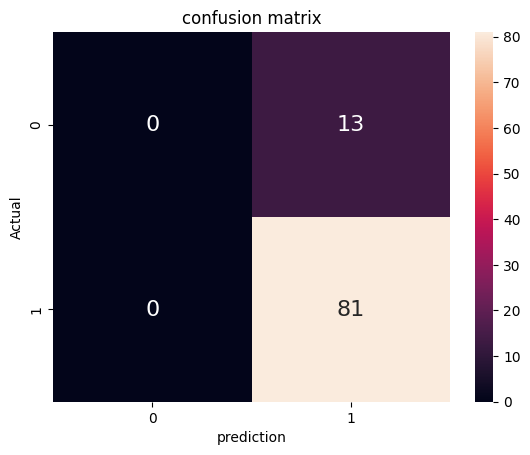

In [ ]:
# Plotting the Confusion Matrix
import pandas as pd
import seaborn
df_cm = pd.DataFrame(cm, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
seaborn .heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

In [ ]:
model.save("textile.h5")